In [10]:
import numpy as np
from qiskit import Aer, QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
from fractions import Fraction
import math

In [11]:
N = 51          # factor(N)
a = 2           # a^r = 1(mod N)
n_count = 4     # 2*(log r)//2
m_count = 6     # log(N)

In [ ]:
# oracle power 2
def c_2mod51(a, power):
    U2 = QuantumCircuit(m_count)        
    for iteration in range(power):
        i = iteration % 8
        if(i == 0):
            U2.x(1) # 2
            U2.x(0)
        if(i == 1):
            U2.x(2) # 4
            U2.x(1)
        if(i == 2):
            U2.x(3) # 8
            U2.x(2)
        if(i == 3):
            U2.x(4) # 16
            U2.x(3)
        if(i == 4):
            U2.x(5) # 32
            U2.x(4)
        if(i == 5):
            U2.x(3) # 13
            U2.x(2)
            U2.x(0) 
            U2.x(5)
        if(i == 6):
            U2.x(4) # 26 = 16 + 8 + 2
            U2.x(1)
            U2.x(2)
            U2.x(0)
        if(i == 7):
            U2.x(4) # 1
            U2.x(3)
            U2.x(1) 
            U2.x(0)
    U3 = U2.to_gate()
    U3.name = "%i^%i mod 51" % (a, power)
    c_U = U3.control()
    return c_U


In [13]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j - m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

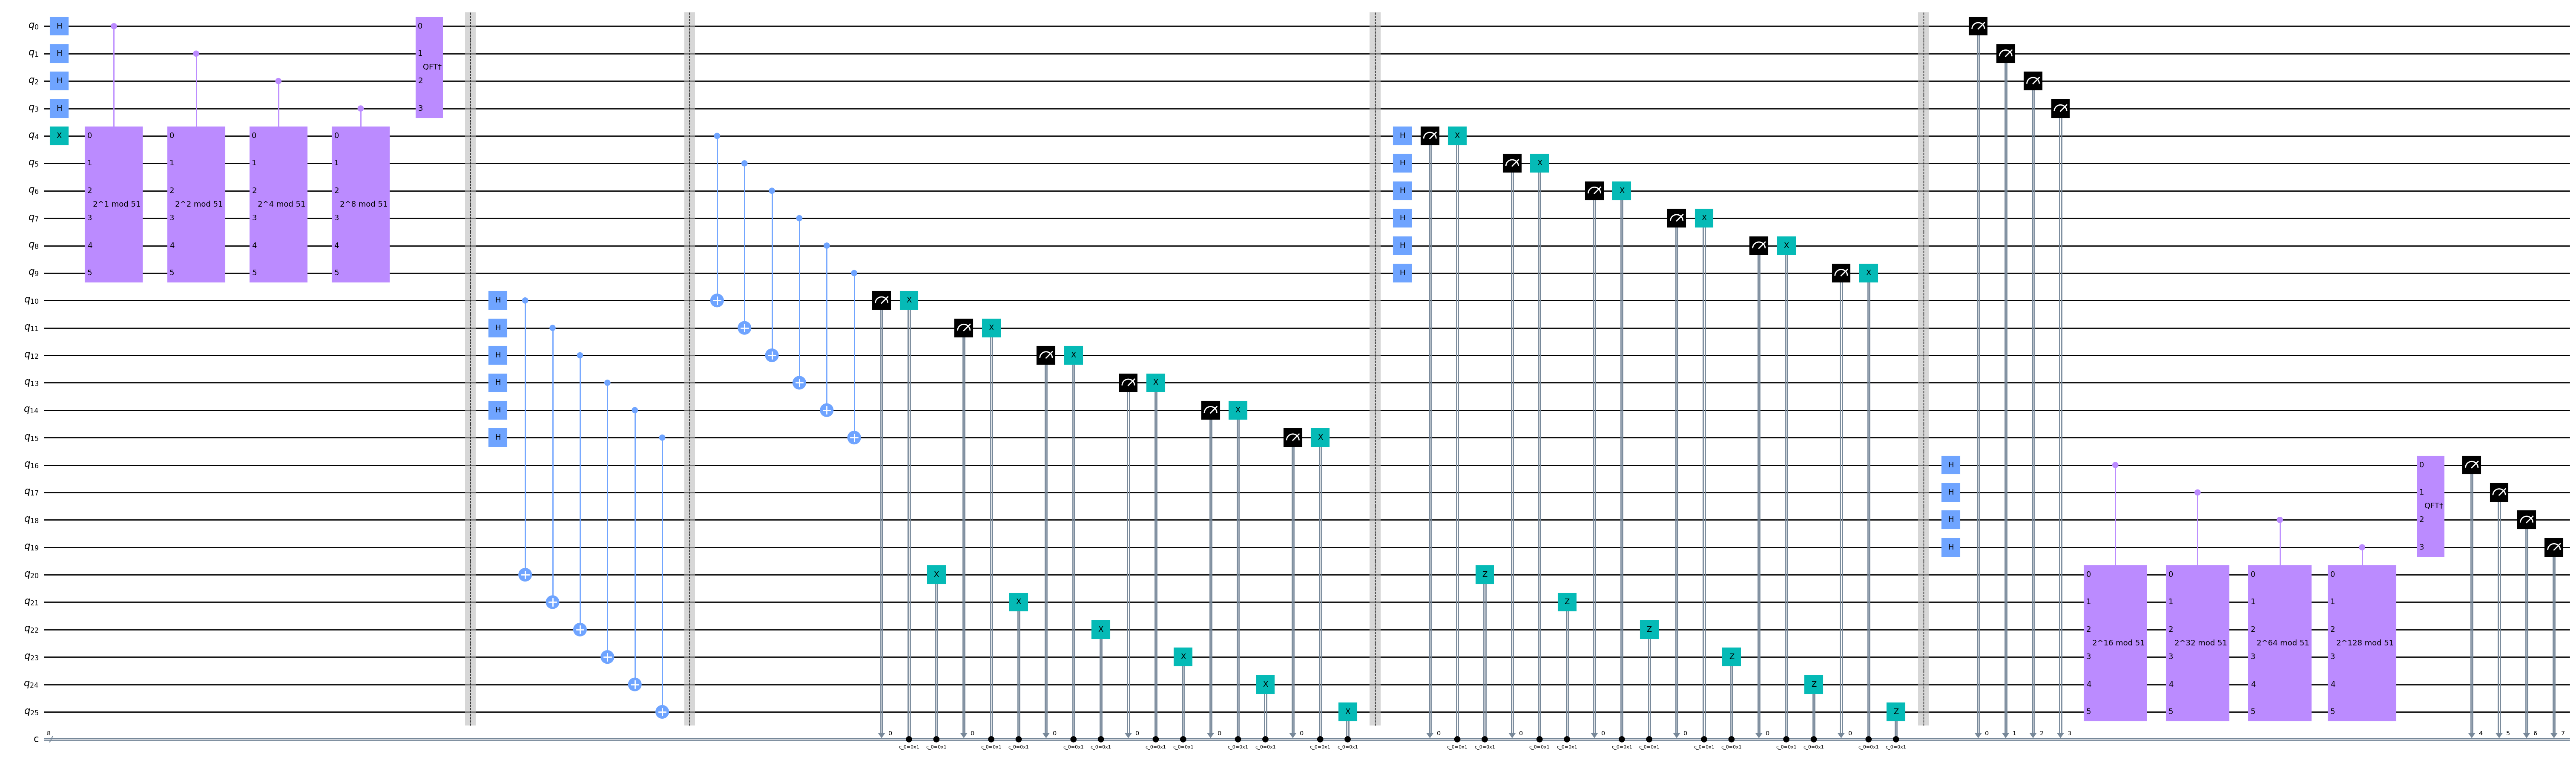

In [ ]:
qc = QuantumCircuit(n_count*2 + m_count*3, n_count*2)
for q in range(n_count):
    qc.h(q)    
qc.x(n_count)

# device1: modular exponentiation
for q in range(n_count):
    qc.append(c_2mod51(a, 2**q), [q] + [i+n_count for i in range(m_count)])

# device1: iQFT
qc.append(qft_dagger(n_count), range(n_count))

qc.barrier()

# teleportation
for q in range(m_count):
    qc.h(n_count + m_count + q)
for q in range(m_count):
    qc.cx(n_count + m_count + q, 2*n_count + 2*m_count + q)
qc.barrier()
for q in range(m_count):
    qc.cx(n_count + q, n_count + m_count + q)
for q in range(m_count):
    qc.measure(n_count + m_count + q, 0)
    qc.x(n_count + m_count + q).c_if(0,1)
    qc.x(2*n_count + 2*m_count + q).c_if(0,1)
qc.barrier()
for q in range(m_count):
    qc.h(n_count + q)
for q in range(m_count):
    qc.measure(n_count + q, 0)
    qc.x(n_count + q).c_if(0,1)
    qc.z(2*n_count + 2*m_count + q).c_if(0,1)
qc.barrier()

# device2: init
for q in range(n_count):
    qc.h(n_count + 2*m_count + q)

# device2: modular exponentiation
for q in range(n_count):
    qc.append(c_2mod51(a, 2**(q+n_count)), [n_count + 2*m_count + q] + [2*n_count + 2*m_count + i for i in range(m_count)])

# device2: iQFT
qc.append(qft_dagger(n_count), range(n_count + 2*m_count, 2*n_count + 2*m_count))


# Measure
qc.measure(range(n_count), range(n_count))
qc.measure(range(n_count+2*m_count, 2*n_count+2*m_count), range(n_count, 2*n_count))
qc.draw('mpl',fold=-1)  # -1 means 'do not fold' 

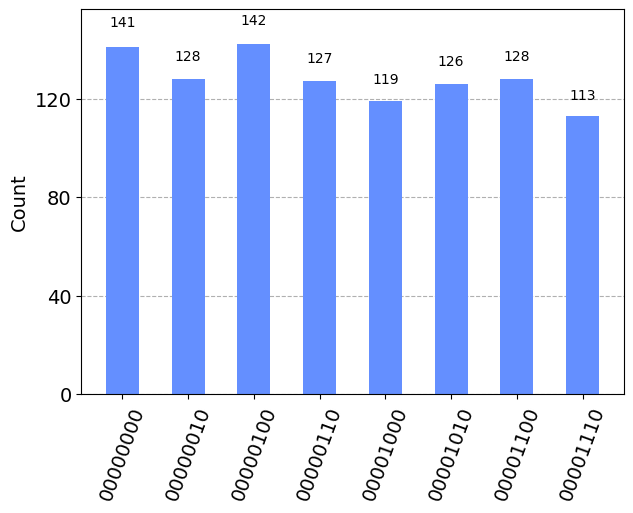

In [15]:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
result = sim.run(t_qc).result()
counts = result.get_counts()
# print("Counts:",counts)
display(plot_histogram(counts))

In [16]:
def continued_fraction_expansion(x, denominator_limit=1000):
    frac = Fraction(x).limit_denominator(denominator_limit)
    return frac.denominator

In [17]:
measured_phases = []
for output in counts:
    decimal = int(output, 2)
    phase = decimal / (2**n_count)
    measured_phases.append(phase)
print("Phases:", measured_phases)
r_values = []
for phase in measured_phases:
    frac_denominator = continued_fraction_expansion(phase)
    r_values.append(frac_denominator)
print("Periods:", r_values)

Phases: [0.875, 0.625, 0.125, 0.25, 0.0, 0.5, 0.375, 0.75]
Periods: [8, 8, 8, 4, 1, 2, 8, 4]


In [18]:
for r in r_values:
    if r % 2 != 0:
        continue
    factor1 = math.gcd(a**(r // 2) - 1, N)
    factor2 = math.gcd(a**(r // 2) + 1, N)
    if factor1 * factor2 == N:
        print(N, "=", factor1, "x", factor2)
        break
else:
    print("failed...")

51 = 3 x 17
